<a href="https://colab.research.google.com/github/ProfDoeg/Colegio_Invisible/blob/main/18_cuaderno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install eciespy eth_keys cryptos qrcode
! git clone https://github.com/ProfDoeg/Colegio_Invisible.git
! cp Colegio_Invisible/modules/colegio_tools.py colegio_tools.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.4 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 2.0 MB 39.9 MB/s 
     |████████████████████████████████| 1.3 MB 44.5 MB/s 
     |████████████████████████████████| 105 kB 38.6 MB/s 
     |████████████████████████████████| 481 kB 49.3 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1236725 sha256=8073e72465b3dd4da37d4d3bc99953e5619cf677fe91c5fba6605d48c32d6643
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
  Created wheel for qrcode: filename=qrcode-7.3.1-py3-none-any.whl size=40402 sha256=8b075931a5aa1ccb614c320b8364567640d2a1804860c171a8e5122e27fd37fb
  Stored in directory: /root/.cache/pip/wheels/93/d7/39/a4111be2cfb8e679938aa671a37888b6afb1f9e7d748e94492
Successfully built cytoolz 

In [4]:
from colegio_tools import *

# Now We Have Colegio Tools

## Load Real Keys

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! cp drive/MyDrive/cinv/llaves.zip llaves.zip 
! unzip llaves.zip

Archive:  llaves.zip
   creating: llaves/
 extracting: llaves/mi_addr.bin      
 extracting: llaves/mi_addr.png      
 extracting: llaves/mi_pub.bin       
 extracting: llaves/mi_prv.enc       


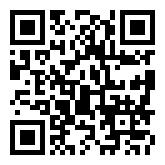

**************************************************
PUBLIC: 0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5
ADDR: D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX
**************************************************
BALANCE:	 1161.917069
NUM_UTXO:	 2
**************************************************


In [7]:
my_qr=IPython.display.Image('llaves/mi_addr.png')
my_privKey=import_privKey('llaves/mi_prv.enc','')
my_pub=import_pubKey('llaves/mi_pub.bin')
my_addr=import_addr('llaves/mi_addr.bin')

display(my_qr)
print('*'*50)
print('PUBLIC:',my_pub)
print('ADDR:',my_addr)

import cryptos
doge=cryptos.Doge()

doge_unspents=doge.unspent(my_addr) 
doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents])

print('*'*50)
print('BALANCE:\t',doge_unspent_total/10**8)
print('NUM_UTXO:\t',len(doge_unspents))
print('*'*50)

# Accessing Encypted Files From Blockchain

We will be accessing an encrypted color image file woven from transaction:

```d0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41```

Remeber the header data contains the following:
```text
b'\xc1\xdd\x00\x01\x0e\x03\x01'+length_bytes+width_bytes+bitnum_bytes+recip_bytes... + some_text_bytes
```

In [ ]:
Txn='d0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41'

(head_d02,bytes_d02)=read_cadenas(Txn)

num_keys=int(head_d02[24:26])
zipkeys=[bytes_d02[i*64:i*64+64] for i in range(num_keys) ]
zipdata=bytes_d02[num_keys*64:]
print('HEADER:',head_d02)

txn_pub_hex=get_txn_pub(Txn)
print('AUTHOR:',txn_pub_hex)
print('NUM_RECIP:',num_keys)

In [ ]:
N=0

txn_pubKey=eth_keys.keys.PublicKey(bytes.fromhex(txn_pub_hex))
my_shared_key=shared_key(my_privKey,txn_pubKey)
ses_kee=ecies.aes_decrypt(my_shared_key,zipkeys[N])
data_do2=ecies.aes_decrypt(ses_kee,zipdata)
array_do2=read_image_data(head_d02,data_do2)

Image.fromarray(array_do2)

In [ ]:

(d68_head,d68_array)=array_dec_from_txn('d68175766b70f7163aec93e5a4e81480a6c6dd51d0577319d6f3392e8725f53b',my_privKey,0)
Image.fromarray(d68_array)

# Key Drop

Create Transaction with op_return 

For key drop header is:

```text
b'\xc1\xdd\x00\x01\x0e\x0e\x0d'+text_bytes
```
and body is:
```
enc_txid_bytes+aes_key_bytes
```


In [ ]:
drop_header=b'\xc1\xdd\x00\x01\x0e\x0e\x0d'+b'|Release something glorious to the world|'
enc_txid_bytes=bytes.fromhex('d0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41')
aes_key_bytes=ses_kee
drop_package=[drop_header]+[enc_txid_bytes+aes_key_bytes]
print(drop_package)

In [ ]:
#prepare
tip=1_00_000_000
available=doge_unspent_total-tip
gift=int(available/len(drop_package))
outputs=[{'value':gift , 'address': my_addr} for i in range(len(drop_package))]
setup_tx=doge.mktx(doge_unspents,outputs)
print(gift/100_000_000)
print(len(outputs))

In [ ]:
doge.signall(setup_tx,my_privKey.to_hex()[2:])

In [ ]:
tip/(len(cryptos.serialize(setup_tx))/2)/100000

In [ ]:
funding=doge.pushtx(cryptos.serialize(setup_tx))
funding

In [ ]:
drop_txid='89b51b4852b0e80f49cdb229d85ef4757d943c9fe4ba62e39e886f31c70142c4'

In [ ]:
doge.fetchtx(funding['data']['txid'])['confirmations']

In [ ]:
drop_unspents=doge.unspent(my_addr)
drop_unspents

In [ ]:
cadenas=[ Cadena(my_privKey.to_hex()[2:],*datum_utxo,100_000_000)for datum_utxo in zip(drop_package,drop_unspents) ]

In [ ]:
import time

height=doge.current_block_height()-1
print(height)
while True:
  check_height=doge.current_block_height()
  if check_height>height:
    height=check_height
    print(height)
    #[cad.make_tx() for cad in cadenas if cad.state=='CONF'];
    #[cad.broadcast() for cad in cadenas if cad.state=='READY'];
    [cad.update() for cad in cadenas if cad.state=='SENT'];
    [cad.make_tx() for cad in cadenas if cad.state=='CONF'];
    [cad.broadcast() for cad in cadenas if cad.state=='READY'];
    print([cad.state for cad in cadenas])
    if all([cad.state=='DONE' for cad in cadenas]):
      break
  time.sleep(10)

# Now We Have a Txn_id for the KeyDrop

```
89b51b4852b0e80f49cdb229d85ef4757d943c9fe4ba62e39e886f31c70142c4
```

We can use this to access the header and data

In [ ]:
drop_txid

In [ ]:
#drop_txid='89b51b4852b0e80f49cdb229d85ef4757d943c9fe4ba62e39e886f31c70142c4'

In [ ]:
(head_89b,body_89b)=read_cadenas(drop_txid)

In [ ]:
droplock_id=body_89b[:32]
drop_key=body_89b[32:]

In [ ]:
(head_lock,body_lock)=read_cadenas(droplock_id.hex())

In [53]:
num_keys=int(head_lock[24:26])
body_unlock=ecies.aes_decrypt(drop_key,body_lock[num_keys*64:])

In [ ]:
array_lock=read_image_data(head_lock,body_unlock)

Image.fromarray(array_lock)

In [10]:
def read_array_drop(txid):
  (head_x,body_x)=read_cadenas(txid)
  dropL_id=body_x[:32]
  drop_K=body_x[32:]
  (head_L,body_L)=read_cadenas(dropL_id.hex())
  num_keys=int(head_L[24:26])
  body_UL=ecies.aes_decrypt(drop_K,body_L[num_keys*64:])
  return read_image_data(head_L,body_UL)

3 64 128 5


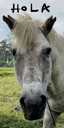

In [11]:
array_secret=read_array_drop('89b51b4852b0e80f49cdb229d85ef4757d943c9fe4ba62e39e886f31c70142c4')
Image.fromarray(array_secret)